In [1]:
!nvidia-smi

Sun May 12 23:33:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   26C    P8             17W /  230W |    1857MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import math
from tqdm.auto import tqdm
from datasets import load_dataset, concatenate_datasets
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

In [3]:
class NoiseScheduler(nn.Module):
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        assert beta_start < beta_end < 1.0, "beta1 and beta2 must be in (0, 1)"

        beta = ((beta_end - beta_start) * torch.arange(0, num_timesteps + 1, dtype=torch.float32) / num_timesteps + beta_start).to(device)
        sqrt_beta = torch.sqrt(beta)
        alpha = 1. - beta
        log_alpha = torch.log(alpha)
        alpha_hat = torch.cumsum(log_alpha, dim=0).exp()
        
        one_over_sqrt_alpha = 1 / torch.sqrt(alpha)
        sqrt_alpha_hat = torch.sqrt(alpha_hat)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat)

        self.register_buffer("beta", beta)
        self.register_buffer("sqrt_beta", sqrt_beta)
        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_hat", alpha_hat)
        self.register_buffer("one_over_sqrt_alpha", one_over_sqrt_alpha)
        self.register_buffer("sqrt_alpha_hat", sqrt_alpha_hat)
        self.register_buffer("sqrt_one_minus_alpha_hat", sqrt_one_minus_alpha_hat)

    def noise_images(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t][:, None, None, None]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t][:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.num_timesteps, size=(n,))

    def denoise(self, noisy_image, predicted_noise, z, t):
        one_over_sqrt_alpha = self.one_over_sqrt_alpha[t]
        pred_noise_coeff = (1 - self.alpha[t])/self.sqrt_one_minus_alpha_hat[t]
        sqrt_beta = self.sqrt_beta[t]
        return (
                one_over_sqrt_alpha * (noisy_image - (pred_noise_coeff * predicted_noise))
                + sqrt_beta * z
            )

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_res=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x):
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
           
            if self.in_channels == self.out_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualBlock(out_channels, out_channels),
            ResidualBlock(out_channels, out_channels),
        )

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.conv(x)
        return x

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ClassEmbedding(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes=2, num_features=64):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_features = num_features

        self.init_conv = ResidualBlock(in_channels, num_features, is_res=True)

        self.down_conv1 = DownBlock(num_features, num_features)
        self.down_conv2 = DownBlock(num_features, 2 * num_features)

        self.mid_block = nn.Sequential(
            nn.AvgPool2d(7), 
            nn.GELU()
        )

        self.time_embedding1 = SinusoidalPositionEmbeddings(2 * num_features)
        self.time_embedding2 = SinusoidalPositionEmbeddings(num_features)

        self.class_embedding1 = nn.Embedding(num_classes, 2 * num_features)
        self.class_embedding2 = nn.Embedding(num_classes, num_features)
        

        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(2 * num_features, 2 * num_features, kernel_size=16, stride=8, padding=4),
            nn.GroupNorm(8, 2 * num_features),
            nn.ReLU(),
        )
    
        self.up_conv1 = UpBlock(4 * num_features, num_features)
        self.up_conv2 = UpBlock(2 * num_features, num_features)
        self.out_conv = nn.Sequential(
            nn.Conv2d(2 * num_features, num_features, 3, 1, 1),
            nn.GroupNorm(8, num_features),
            nn.ReLU(),
            nn.Conv2d(num_features, self.in_channels, 3, 1, 1)
        )

    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1_out = self.down_conv1(x)
        down2_out = self.down_conv2(down1_out)
        mid_out = self.mid_block(down2_out)
        
        class_emb1 = self.class_embedding1(c).view(-1, self.num_features * 2, 1, 1) * context_mask[:, None, None, None]
        time_emb1 = self.time_embedding1(t).view(-1, self.num_features * 2, 1, 1)
        class_emb2 = self.class_embedding2(c).view(-1, self.num_features, 1, 1) * context_mask[:, None, None, None]
        time_emb2 = self.time_embedding2(t).view(-1, self.num_features, 1, 1)
        
        upsample_out = self.upsample(mid_out)

        up2_out = self.up_conv1(class_emb1 * upsample_out + time_emb1, down2_out)  
        up3_out = self.up_conv2(class_emb2 * up2_out + time_emb2, down1_out)
        out = self.out_conv(torch.cat((up3_out, x), 1))
        return out


In [5]:
class Diffuser(nn.Module):
    def __init__(
        self,
        unet,
        noise_scheduler,
        num_timesteps,
        num_classes,
        eta=0.,
        drop_prob=0.1
    ):
        super().__init__()
        self.unet = unet
        self.num_timesteps = num_timesteps
        self.num_classes = num_classes
        self.criterion = nn.MSELoss()
        self.eta = eta
        self.noise_scheduler = noise_scheduler
        self.drop_prob = drop_prob

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))
    
    def forward(self, x, labels=None):
        timesteps = torch.randint(1, self.num_timesteps + 1, (x.shape[0],)).to(x.device)
        noisy_x, noise = self.noise_scheduler.noise_images(x, timesteps)
        context_mask = torch.bernoulli(torch.zeros_like(labels) + (1 - self.drop_prob)).to(x.device)
        predicted_noise = self.unet(noisy_x, labels, timesteps / self.num_timesteps, context_mask)
        return self.criterion(noise, predicted_noise)
   
    def convert_images_to_class(self, x, labels, size, device, num_steps=None):
        if num_steps is None:
            num_steps = self.num_timesteps
        n_samples = x.shape[0]
        x = x.to(device)
        labels = labels.to(device)
        context_mask = torch.ones_like(labels).to(device)
        for t in tqdm(range(num_steps, 0, -1), desc="Sampling images", leave=False):
            z = torch.randn(n_samples, *size).to(device) if t > 1 else 0
            predicted_noise = self.unet(
                x, 
                labels, 
                torch.tensor(t / self.num_timesteps).to(device).repeat(n_samples, ), 
                context_mask
            )
            x = self.noise_scheduler.denoise(x, predicted_noise, z, t)
        return x


In [6]:
device = "cuda"
num_channels = 3
num_classes = 2
num_timesteps = 600
unet = UNet(num_channels, num_classes).to(device)
scheduler = NoiseScheduler(num_timesteps)
ddpm_model = Diffuser(
    unet,
    scheduler,
    num_timesteps=num_timesteps,
    num_classes=num_classes,
    eta=0.3,
).to(device)
ddpm_model.load_state_dict(torch.load("./models/ddpm_latest.pth"))

<All keys matched successfully>

In [7]:
from datasets import load_from_disk
ds = load_from_disk("image-data/test")
summer = ds.filter(lambda x: x["label"] == 0).take(100)
winter = ds.filter(lambda x: x["label"] == 1).take(100)
ds_sub = concatenate_datasets([summer, winter])

In [8]:
ds

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

In [9]:
img_size = 128
preprocess = transforms.Compose(  # resize to 512 x 512, convert to tensor, normalize
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = [label for label in examples["label"]]
    return {"images": images, "labels": labels}

summer.set_transform(transform)
winter.set_transform(transform)

In [10]:
plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


tensor([0., 0., 1., 1.], device='cuda:0')

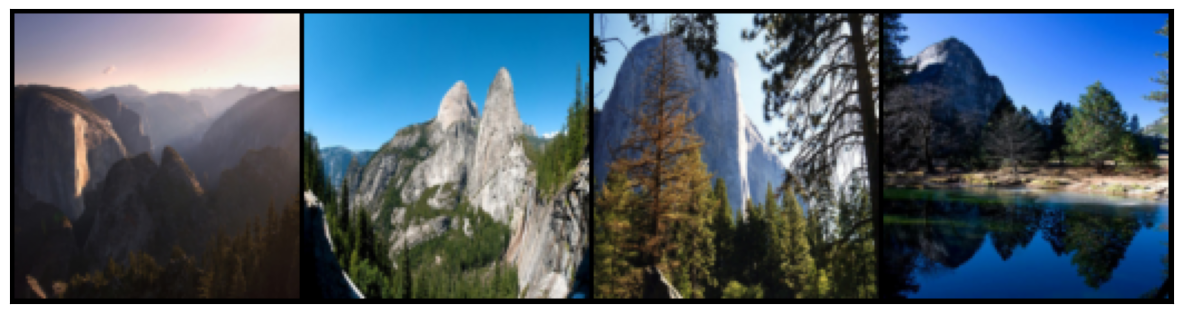

In [11]:
idx = 53
summer_images = torch.cat([s.unsqueeze(0) for s in summer[idx:idx+2]["images"]], dim=0)
winter_images = torch.cat([s.unsqueeze(0) for s in winter[idx:idx+2]["images"]], dim=0)
summer_labels = summer[idx:idx+2]["labels"]
winter_labels = winter[idx:idx+2]["labels"]
images = torch.cat([summer_images, winter_images], dim=0).to(device)
labels = torch.Tensor(summer_labels + winter_labels).to(device)
show(make_grid(images, normalize=True, value_range=(-1, 1)))
labels

Sampling images:   0%|          | 0/430 [00:00<?, ?it/s]

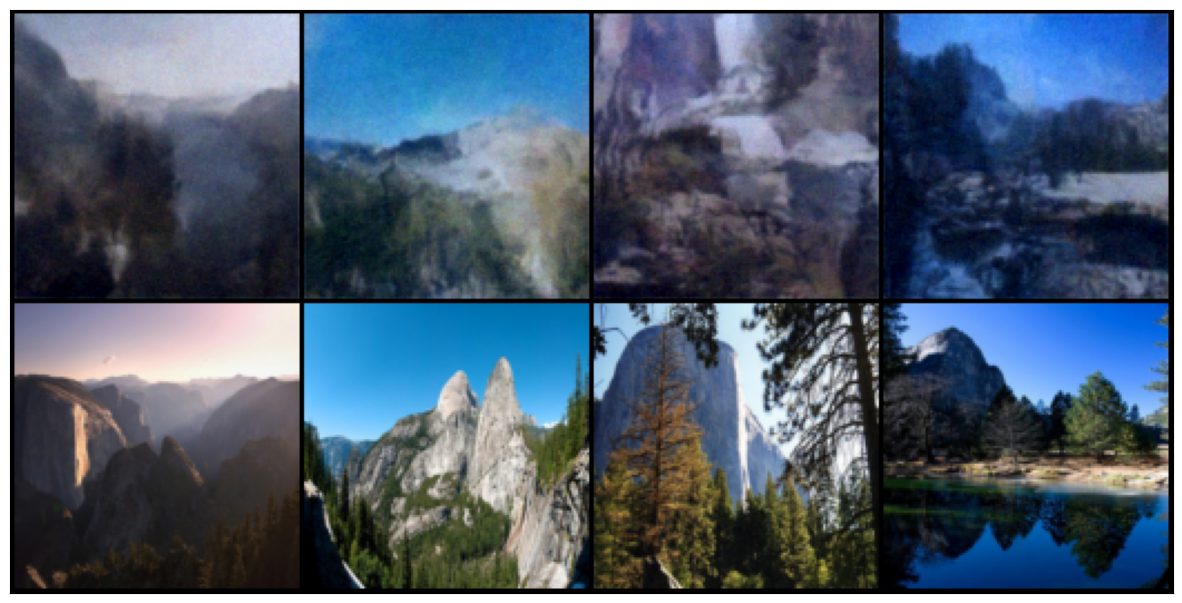

In [12]:
with torch.no_grad():
    eval_images = images.to(device)
    convert_to_labels = (1 - labels).to(device).long()
    noised_eval_images, _ = ddpm_model.noise_scheduler.noise_images(eval_images, torch.tensor([450]).to(device))
    
    samples = ddpm_model.convert_images_to_class(
        noised_eval_images, 
        convert_to_labels, 
        (3, img_size, img_size), 
        device, 
        num_steps=430
    )
    sample_set = torch.cat([samples, eval_images], dim=0)
    show(make_grid(sample_set, normalize=True, value_range=(-1, 1), nrow=4))